## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',100)
pd.set_option('Display.max_rows',100)

## Import Dataset

In [3]:
path    = "../final_assignment_public/Telecom_customer_churn.csv"
df      = pd.read_csv( path )

print( 'df:\n{} rows × {} columns\n'.format( df.shape[0], df.shape[1] ) )

df:
100000 rows × 100 columns



In [4]:
path = '../csv/f_imp_core.csv'
df_feature = pd.read_csv( path, index_col=0 )

print( 'df_feature:\n{} rows × {} columns\n'.format( df_feature.shape[0], df_feature.shape[1] ) )

df_feature:
22 rows × 1 columns



In [5]:
# 重要度が高い22種類のカラムだけ取得
df_core = df[df_feature['feature']]
df_core['churn'] = df['churn']

## Data Preprocessing

### Categorical data

In [6]:
# カテゴリカル変数を表示
x_cat = df_core[df_core.select_dtypes( include=object ).columns].columns

# カテゴリカル変数を落とす(理解不能なため)
df_core = df_core.drop( columns=x_cat )

### Numerical data

In [7]:
def check_null( _df ):
    print( _df.isnull().sum() )

In [8]:
# 欠損が多いカラムを落とす
df_core = df_core.drop( columns='lor' )

In [9]:
# 不要なカラム(groupbyの結果，解約者と非解約者で差がないデータ)を落とす
df_core = df_core[ ['churn', 'eqpdays', 'change_mou', 'hnd_price', 'change_rev'] ]

In [10]:
# 欠損値を埋める
df_core['eqpdays']      = df_core['eqpdays'].fillna( df_core['eqpdays'].median() )
df_core['hnd_price']    = df_core['hnd_price'].fillna( df_core['hnd_price'].median() )
df_core['change_mou']   = df_core['change_mou'].fillna( df_core['change_mou'].median() )
df_core['change_rev']   = df_core['change_rev'].fillna( df_core['change_rev'].median() )

check_null( df_core )

churn         0
eqpdays       0
change_mou    0
hnd_price     0
change_rev    0
dtype: int64


## EDA

In [11]:
df_core['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

In [12]:
def plot_churn_ratio():
    plt.rcParams["figure.figsize"] = (7, 7)
    plt.pie( df_core['churn'].value_counts(), counterclock=True, startangle=90, colors=['tab:blue','tab:orange'])
    plt.show()

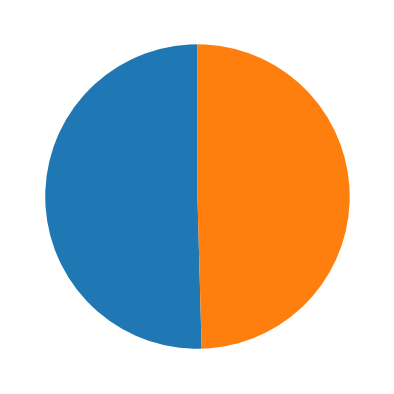

In [13]:
plot_churn_ratio()

### 残った4種類のデータ
|  重要度  |  カラム名  |  内容  |  分類  |
| ---- | ---- | ---- | ---- |
|  1  |  eqpdays  |  現在の端末の使用日数  |  使用日数  |
|  2  |  change_mou  |  過去3か月の毎月の平均使用時間の変化率(%)  |  使用時間  |
|  3  |  hnd_price  |  現在の携帯電話の料金  |  料金  |
|  4 |  change_rev  |  過去3か月の毎月の平均収入の変化率(%)  |  収入  |

### 解約者の特徴を分析する

In [14]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].mean() ) )

churn
0    0
1    1
Name: churn, dtype: int64

churn
0    363.280503
1    421.089524
Name: eqpdays, dtype: float64

churn
0    -5.348090
1   -22.533162
Name: change_mou, dtype: float64

churn
0    108.042847
1     95.567449
Name: hnd_price, dtype: float64

churn
0   -1.405570
1   -0.617074
Name: change_rev, dtype: float64



In [15]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].median() ) )

churn
0    0
1    1
Name: churn, dtype: int64

churn
0    310.0
1    366.0
Name: eqpdays, dtype: float64

churn
0   -3.25
1   -8.75
Name: change_mou, dtype: float64

churn
0    129.98999
1     99.98999
Name: hnd_price, dtype: float64

churn
0   -0.31375
1   -0.31500
Name: change_rev, dtype: float64



In [16]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].std() ) )

churn
0    0.0
1    0.0
Name: churn, dtype: float64

churn
0    249.983678
1    259.705607
Name: eqpdays, dtype: float64

churn
0    249.710614
1    298.029615
Name: change_mou, dtype: float64

churn
0    60.803267
1    60.040092
Name: hnd_price, dtype: float64

churn
0    35.920965
1    61.308744
Name: change_rev, dtype: float64



In [17]:
def plot( _y, _ylabel ):
    plt.rcParams["figure.figsize"] = (10, 10)
    # plt.title( 'Cumulative Feature Importance', fontsize=24 )

    # parameters
    x = [0, 1]
    bar_width = 0.5
    line_width = 0.5

    plt.bar( x[0], _y[0], bar_width, edgecolor='black', linewidth=line_width )
    plt.bar( x[1], _y[1], bar_width, edgecolor='black', linewidth=line_width )

    plt.xticks( [0, 1], fontsize=20 )
    plt.yticks( fontsize=20 )
    plt.xlabel( 'churn', fontsize=24 )
    plt.ylabel( _ylabel, fontsize=24 )
    plt.show()

#### 1. eqpday(現在の端末の使用日数)

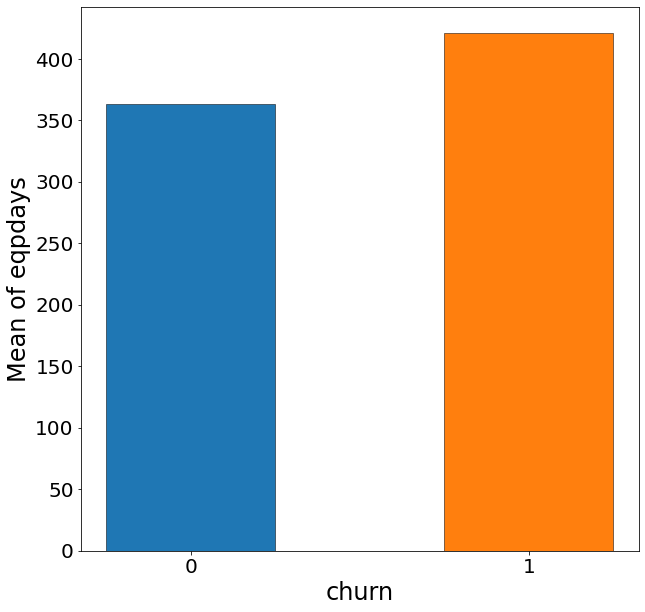

In [18]:
plot( df_core.groupby('churn')['eqpdays'].mean(), 'Mean of eqpdays' )

#### 2. change_mou(過去3か月の月間平均使用時間の変化率(%))

In [19]:
# 平均と標準偏差を計算
change_mou_mean = df_core['change_mou'].mean()
change_mou_std = df_core['change_mou'].std()

# 閾値を計算
change_mou_th_upper = change_mou_mean + 2*change_mou_std
change_mou_th_lower = change_mou_mean - 2*change_mou_std

# 外れ値を除去
df_change_mou = df_core[ (df_core['change_mou'] < change_mou_th_upper) & (df_core['change_mou'] > change_mou_th_lower) ]
df_change_mou = df_change_mou[ ['change_mou', 'churn'] ]

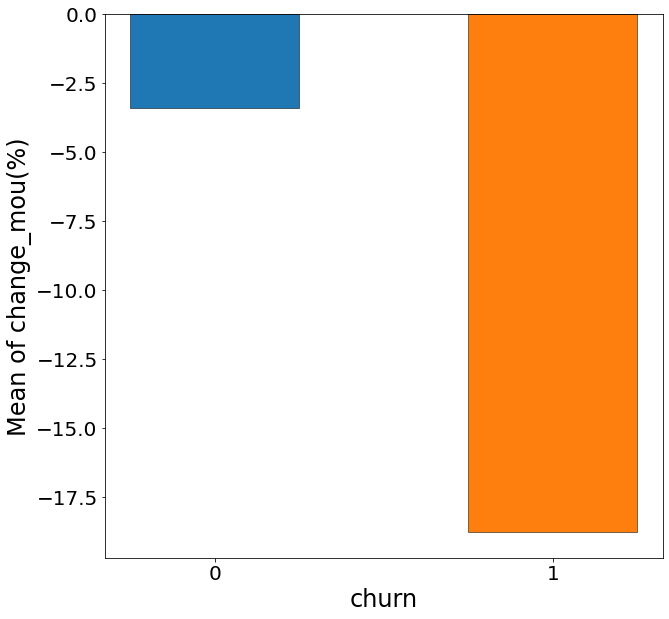

In [20]:
# plot( df_core.groupby('churn')['change_mou'].mean(), 'Mean of change_mou(%)' )
plot( df_change_mou.groupby('churn')['change_mou'].mean(), 'Mean of change_mou(%)' )

#### 3. hnd_price(現在の携帯電話の価格)

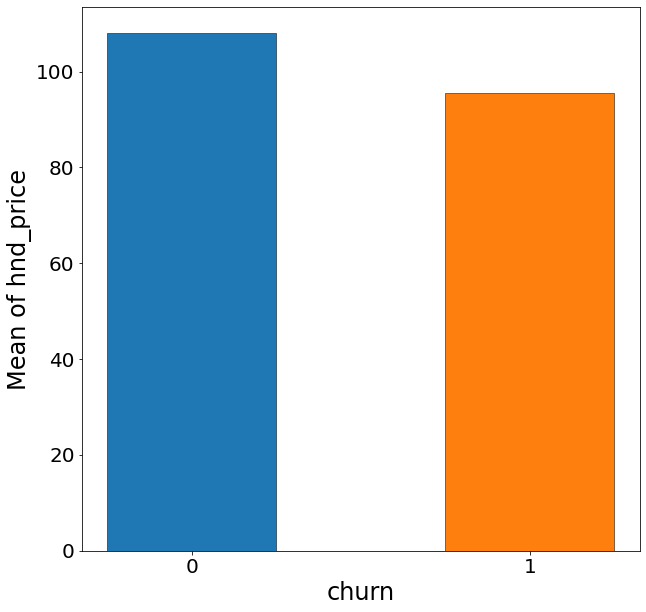

In [21]:
plot( df_core.groupby('churn')['hnd_price'].mean(), 'Mean of hnd_price' )

#### 4. change_rev(過去3か月間の月間平均収入の変化率(%))

In [22]:
# 平均と標準偏差を計算
change_rev_mean = df_core['change_rev'].mean()
change_rev_std = df_core['change_rev'].std()

# 閾値を計算
change_rev_th_upper = change_rev_mean + 2*change_rev_std
change_rev_th_lower = change_rev_mean - 2*change_rev_std

# 外れ値を除去
df_change_rev = df_core[ (df_core['change_rev'] < change_rev_th_upper) & (df_core['change_rev'] > change_rev_th_lower) ]
df_change_rev = df_change_rev[ ['change_rev', 'churn'] ]

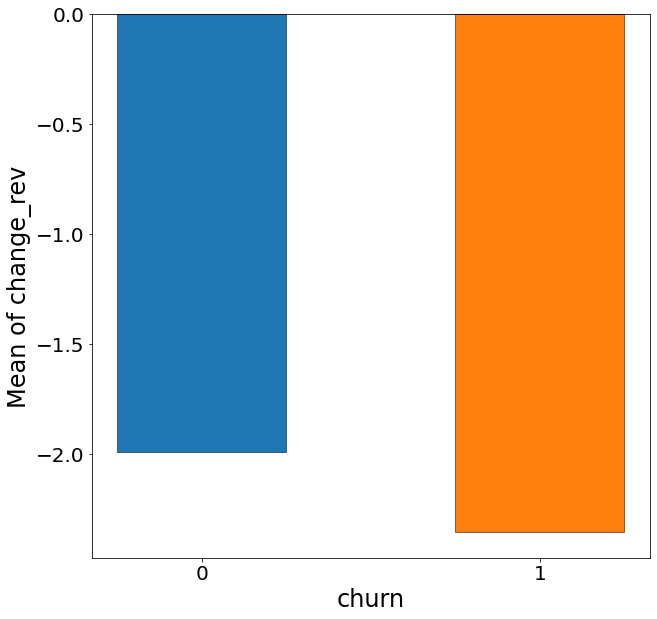

In [23]:
# plot( df_core.groupby('churn')['change_rev'].mean(), 'Mean of change_rev' )
plot( df_change_rev.groupby('churn')['change_rev'].mean(), 'Mean of change_rev' )

## Export to csv file

In [25]:
df_core.to_csv( '../csv/df_core.csv' )

## 4つの特徴量について，非解約者の分布を確認

In [28]:
df_churn0 = df_core[df_core['churn'] == 0]
df_churn1 = df_core[df_core['churn'] == 1]

In [57]:
def plot_dist( _df, _feature, _bins=100 ):
    plt.rcParams["figure.figsize"] = (10, 10)

    sns.distplot( _df[_feature], kde=True, bins=_bins, color='#1e77b4' )

In [42]:
def plot_2dist( _df0, _df1,  _feature, _bins=100 ):
    plt.rcParams["figure.figsize"] = (10, 8)

    sns.distplot( _df0[_feature], kde=True, bins=_bins, color='#1e77b4' )
    sns.distplot( _df1[_feature], kde=True, bins=_bins, color='#f97f10' )

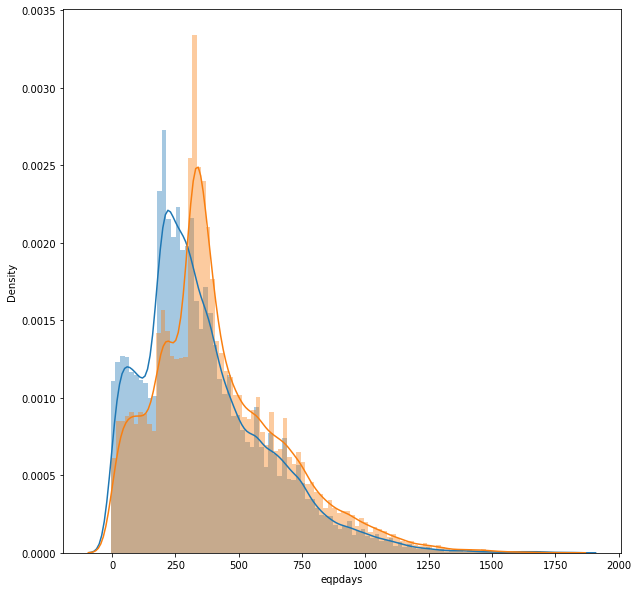

In [36]:
plot_dist( df_churn0, df_churn1, 'eqpdays', 100 )

In [69]:
def plot_box( _df, _feature ):
    plt.rcParams["figure.figsize"] = (10, 10)

    sns.boxplot( _df[_feature], color='#1e77b4', linewidth=2.5 )

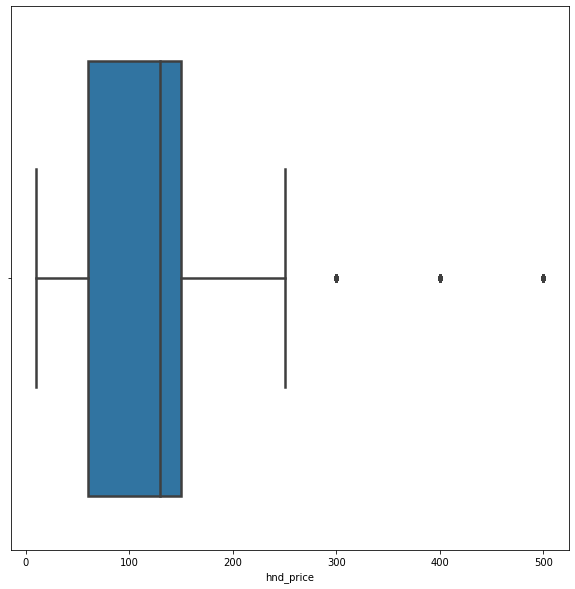

In [74]:
# plot_dist( df_churn0, 'hnd_price', 30 )

display( df_churn0['hnd_price'].describe() )
plot_box( df_churn0, 'hnd_price' )

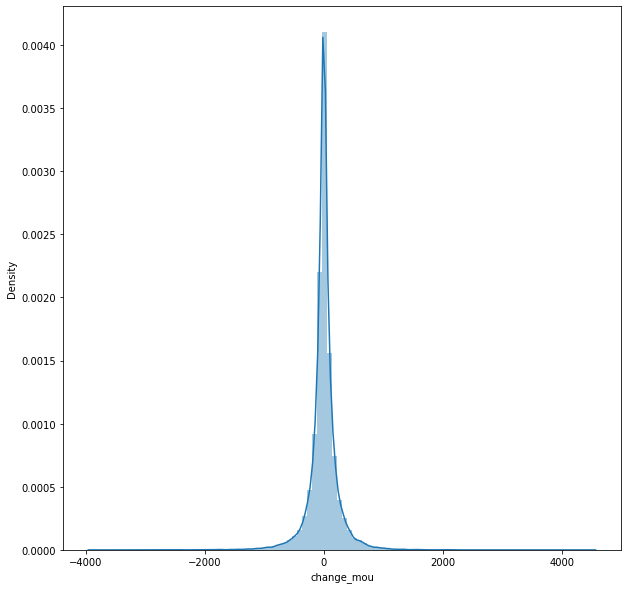

In [27]:
plot_dist( 'change_mou', 100 )

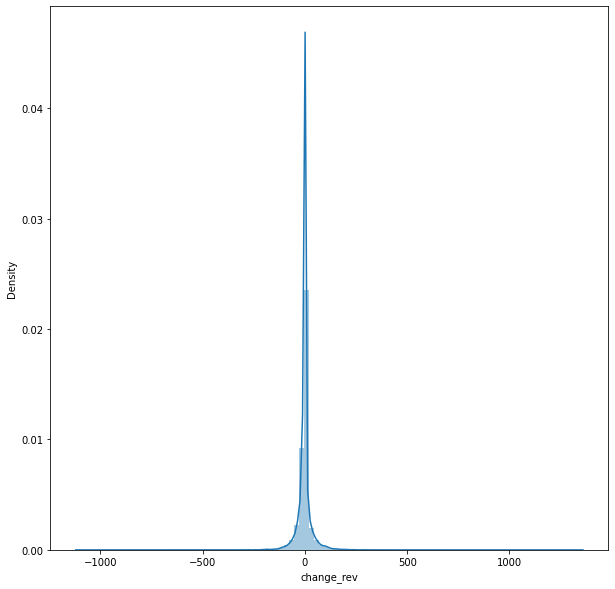

In [26]:
plot_dist( 'change_rev', 100 )